In [1]:
from tidyverse.dummy import *
import scanpy as sc
from ecm_tools import plot_gene
import sys
sys.path.append('..')
plt.rcParams["figure.figsize"] = (4,3)

import decoupler as dc
from matplotlib_inline.backend_inline import set_matplotlib_formats
from colormaps import color_dict_coarse_celltype, color_dict_diagnosis
from ecm_de_data import load_ECM_M_vs_T, load_ECM_NE_vs_M, load_ECM_NE_vs_T, cmap_updown

plt.ion()

import sys
sys.path.append('..')
from util import load_merged_data

Importing tidyverse


In [2]:
plotfolder = '/tmp/ECM_NE_vs_T'
import os
if not os.path.exists(plotfolder):
    os.mkdir(plotfolder)

In [3]:
df_NE_vs_T =load_ECM_NE_vs_T()
df_NE_vs_T['Pvalue_clipped'] = np.clip(df_NE_vs_T['Pvalue'] , 1e-50,  1)

In [4]:
df_NE_vs_T.query('qvalue<0.001 and log2fc < -0.58').shape

(55, 8)

In [5]:
df_NE_vs_T.query('qvalue<0.001 and log2fc > 0.58').shape

(43, 8)

## Volcano plots

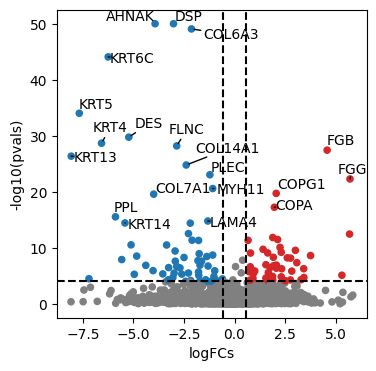

In [6]:
dc.plot_volcano_df(
    df_NE_vs_T.set_index('gene'), x='log2fc', y='Pvalue_clipped', 
    sign_thr=0.0001,
    lFCs_thr=0.58, top=20, 
    # lFCs_limit=7.5, 
    figsize=(4,4), save=f'{plotfolder}/volcano.svg')

In [7]:
df_NE_vs_T.query('(log2fc<-0.58 or log2fc>0.58) and Pvalue<0.0001')

,log2fc,qvalue,gene,Comparison (group1/group2),# of Ratios,Pvalue,up_or_down,Pvalue_clipped
20,3.29,7.710000e-04,IGHA2,Tumor / AdjN,80,5.140000e-05,up,5.140000e-05
23,-5.42,2.670000e-13,KRT14,Tumor / AdjN,228,3.790000e-15,down,3.790000e-15
26,5.69,2.220000e-11,FGA,Tumor / AdjN,264,3.630000e-13,up,3.630000e-13
32,-2.86,5.270000e-06,ANXA1,Tumor / AdjN,124,2.240000e-07,down,2.240000e-07
47,2.83,2.950000e-05,PFN1,Tumor / AdjN,68,1.500000e-06,up,1.500000e-06
...,...,...,...,...,...,...,...,...
4298,-2.61,9.050000e-05,DSC2,Tumor / AdjN,44,5.200000e-06,down,5.200000e-06
4331,-1.02,2.240000e-04,SPTBN2,Tumor / AdjN,36,1.370000e-05,down,1.370000e-05
4496,-7.20,5.220000e-04,KRT15,Tumor / AdjN,24,3.400000e-05,down,3.400000e-05
4946,-1.78,4.050000e-05,NES,Tumor / AdjN,36,2.120000e-06,down,2.120000e-06


# scRNAseq

In [8]:
ECM_patients = ['E07', 'E14','E20','E21', 'E24','E26']
ECM_diagnosis =['NE', 'T']

In [9]:
A = load_merged_data()

# add CNV calls
df_cnv = pd.read_csv('/users/mstrasse/CRUK-code/notebooks/CNVs/O_full.csv', index_col=0)
A.obs.index = A.obs.index.map(lambda x: '-'.join(x.split('-')[:2]))
A.obs = A.obs.merge(df_cnv[['cnv_celltype_split','has_cnv','cnv_avg','cnv_leiden', 'cnv_score', 'ss']], left_index=True, right_index=True, how='left')
A.obs.cnv_leiden = pd.Categorical(A.obs.cnv_leiden)

/tmp/ipykernel_195654/2650541956.py:4: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.


In [10]:
A = A[A.obs.patient.isin(ECM_patients)]
A = A[A.obs.diagnosis.isin(ECM_diagnosis)].copy()
A.raw = A

In [11]:
import gc
gc.collect()

6233

In [12]:
cluster_order = [
    'Columnar Epithelium', 
    'Squamous Epithelium',
    'Bcells', 
    'Tcells',
    'Mast cells', 
    'Myeloid',
    'Endothelial cells', 
    'Fibroblasts',
    'Myofibroblasts',
    'Other'
]

A.obs.celltype_split = pd.Categorical(A.obs.celltype_split, cluster_order)

In [13]:
A.obs['celltype_split_cnv_augmented'] = A.obs['celltype_split'].astype(str)
A.obs.loc[A.obs.query('celltype_split=="Columnar Epithelium" and has_cnv=="yes"').index, 'celltype_split_cnv_augmented'] = "Columnar Epithelium (CNV+)"
A.obs.loc[A.obs.query('celltype_split=="Columnar Epithelium" and has_cnv=="no"').index, 'celltype_split_cnv_augmented'] = "Columnar Epithelium (CNV-)"

_c = ['Columnar Epithelium (CNV-)', 'Columnar Epithelium (CNV+)', 'Squamous Epithelium', 'Bcells', 'Tcells', 'Mast cells', 'Myeloid', 'Endothelial cells', 'Fibroblasts',  'Myofibroblasts', 'Other']
A.obs.celltype_split_cnv_augmented = pd.Categorical(A.obs.celltype_split_cnv_augmented, _c) 

pd.crosstab(A.obs.celltype_split_cnv_augmented, A.obs.has_cnv)

has_cnv,no,yes
celltype_split_cnv_augmented,,
Columnar Epithelium (CNV-),2185,0
Columnar Epithelium (CNV+),0,5546
Squamous Epithelium,2632,17
Bcells,1043,0
Tcells,10231,0
Mast cells,1488,0
Myeloid,2228,0
Endothelial cells,5046,0
Fibroblasts,1999,0


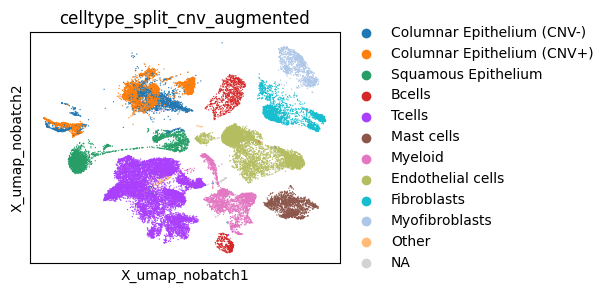

In [14]:
sc.pl.embedding(A, basis='X_umap_nobatch', color=['celltype_split_cnv_augmented'])

# NE vs T differential expression

In [15]:
genes_up = sorted(df_NE_vs_T.query('qvalue<0.001 and log2fc>0.58').gene.values)
genes_down = sorted(df_NE_vs_T.query('qvalue<0.001 and log2fc<-0.58').gene.values)

## ECM-DE vs cell types

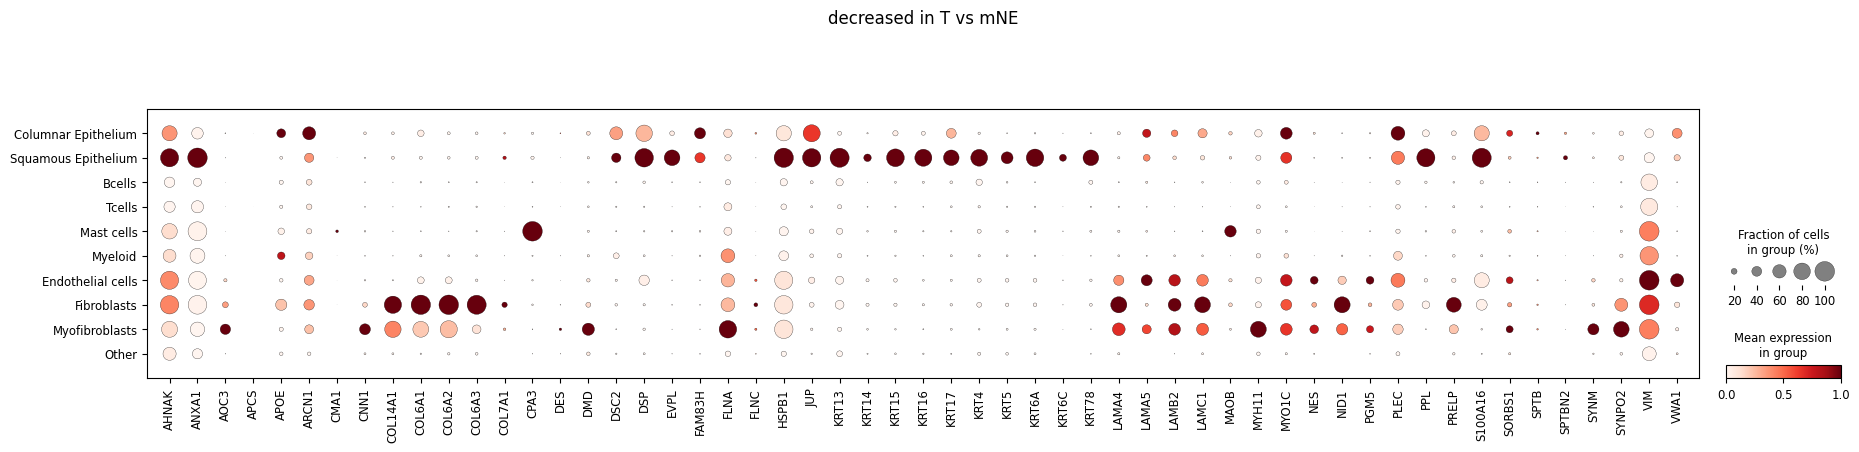

In [16]:
sc.pl.dotplot(A, var_names=genes_down, groupby='celltype_split', standard_scale='var', dendrogram=False, show=False, title='decreased in T vs mNE');
plt.savefig(f'{plotfolder}/ECM_singlecellsource_downreg.svg')

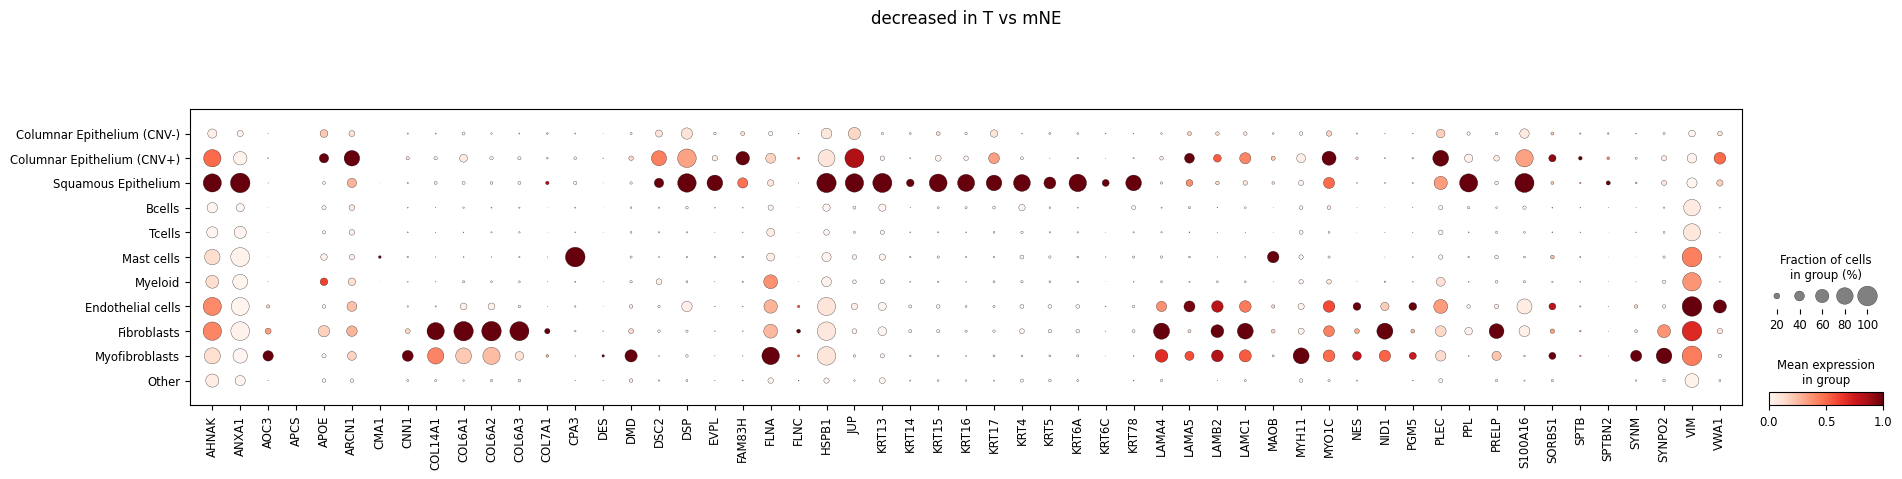

In [17]:
sc.pl.dotplot(A, var_names=genes_down, groupby='celltype_split_cnv_augmented', standard_scale='var', dendrogram=False, show=False, title='decreased in T vs mNE');
plt.savefig(f'{plotfolder}/ECM_singlecellsource_downreg_cnv_aug.svg')

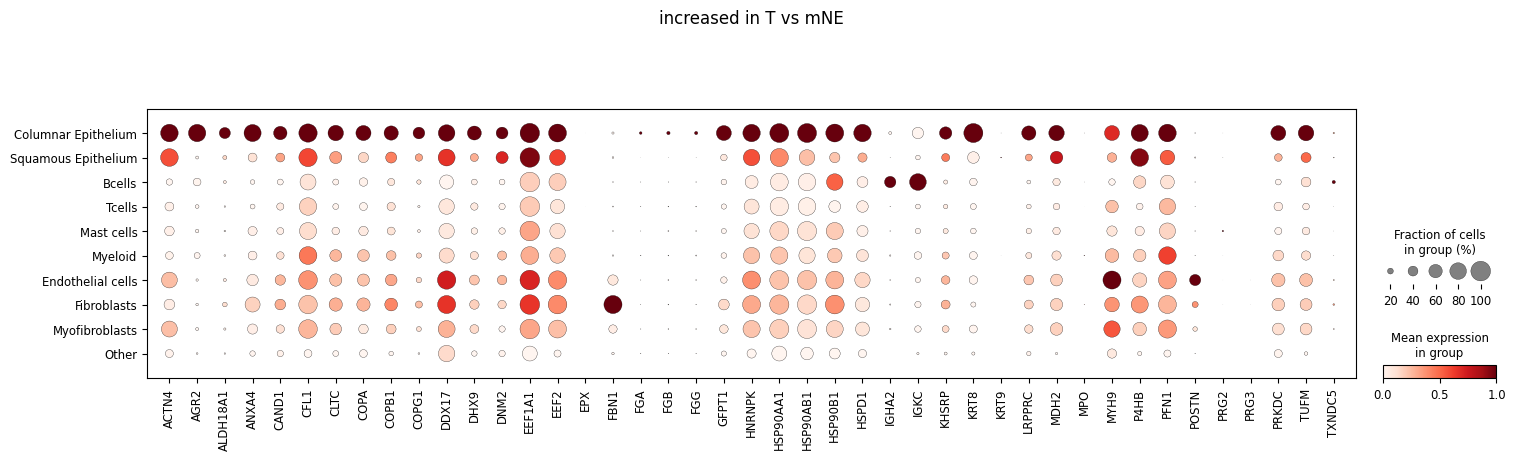

In [18]:
sc.pl.dotplot(A, var_names=genes_up, groupby='celltype_split', standard_scale='var', dendrogram=False, show=False, title='increased in T vs mNE');
plt.savefig(f'{plotfolder}/ECM_singlecellsource_upreg.svg')

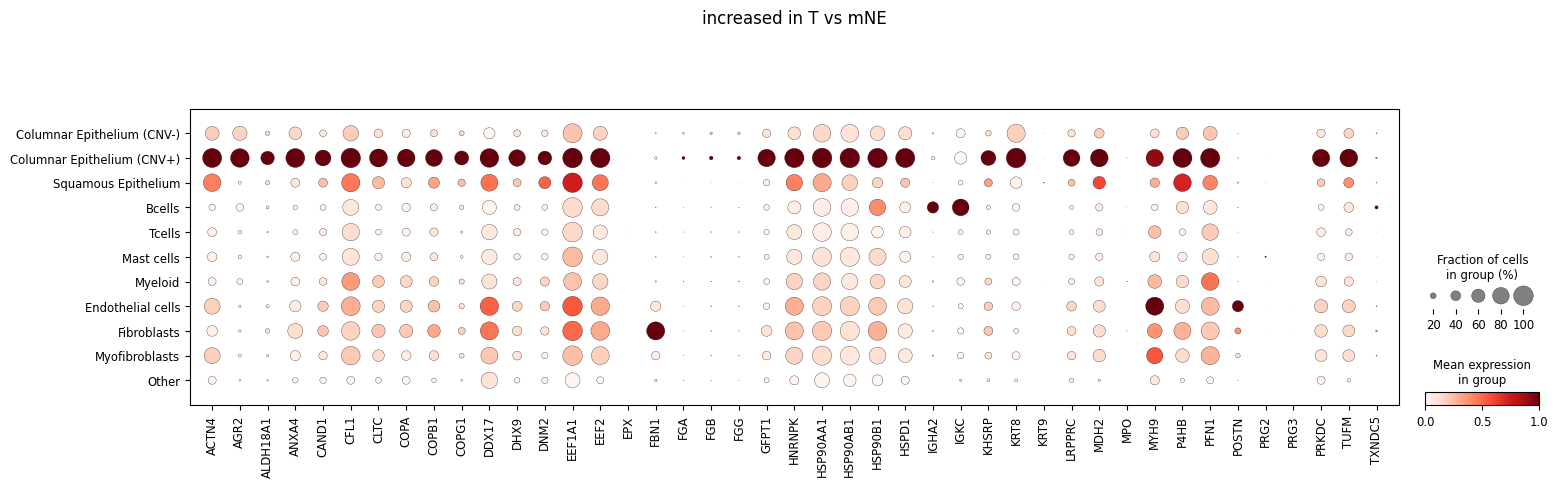

In [19]:
sc.pl.dotplot(A, var_names=genes_up, groupby='celltype_split_cnv_augmented', standard_scale='var', dendrogram=False, show=False, title='increased in T vs mNE');
plt.savefig(f'{plotfolder}/ECM_singlecellsource_upreg_cnv_aug.svg')

In [20]:
_d = A.obs.groupby(['celltype_split_cnv_augmented','diagnosis']).samplename.count().reset_index().rename({'samplename': 'n_cells'}, axis=1)
celltype_total = _d .groupby('celltype_split_cnv_augmented').n_cells.sum().to_dict()
_d['total'] = _d.celltype_split_cnv_augmented.apply(lambda x: celltype_total[x]).astype(int)
_d['percent_cells'] = _d.n_cells / _d.total
# reverse order so it works in the flipped diagram
_d['celltype_split_cnv_augmented'] = pd.Categorical(_d['celltype_split_cnv_augmented'] , _d['celltype_split_cnv_augmented'].cat.categories[::-1])
_d.head()

,celltype_split_cnv_augmented,diagnosis,n_cells,total,percent_cells
0,Columnar Epithelium (CNV-),NE,112,2185,0.051259
1,Columnar Epithelium (CNV-),T,2073,2185,0.948741
2,Columnar Epithelium (CNV+),NE,0,5546,0.000000
3,Columnar Epithelium (CNV+),T,5546,5546,1.000000
4,Squamous Epithelium,NE,2627,2649,0.991695


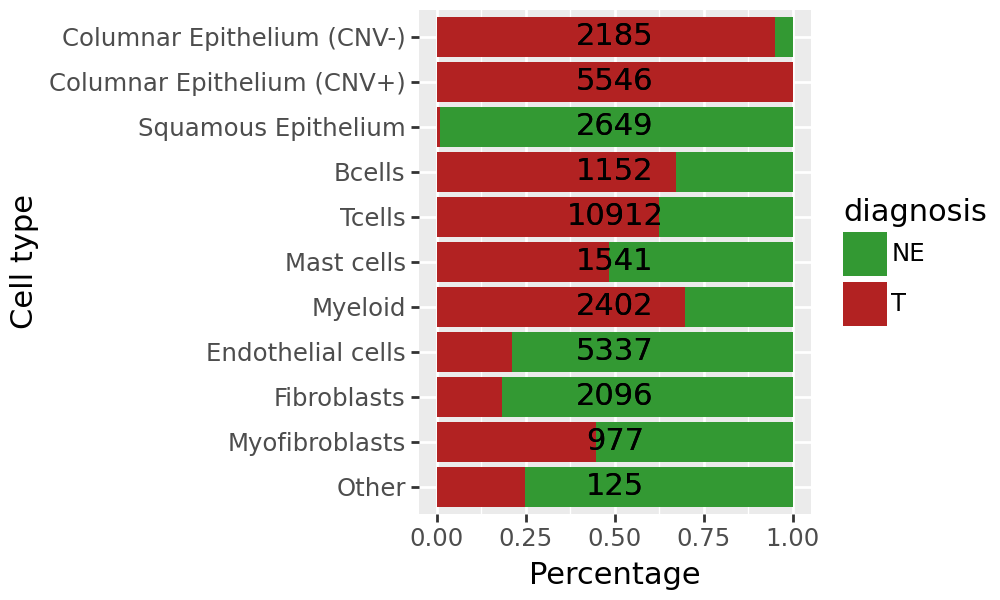

In [21]:
pn.ggplot(_d) +pn.aes(x='celltype_split_cnv_augmented', fill='diagnosis', y='percent_cells') + pn.geom_bar(stat='identity') \
+ pn.geom_text(data=_d, mapping=pn.aes( x='celltype_split_cnv_augmented', y=0.5, label='total')) \
+ pn.coord_flip()+pn.theme(figure_size=(5,3)) + pn.labs(y='Percentage', x='Cell type') + pn.scale_fill_manual(color_dict_diagnosis)

# General fold change in proteomics vs scrnaseq 
independent of cell type etc

In [22]:
from ecm_tools import fold_change_pseudobulk_fixed
adata_bulk_de = dc.get_pseudobulk(
        A,
        sample_col='samplename', 
        groups_col=None,
        use_raw=False,
        mode='sum',
        min_cells=0,
        # min_counts=10000,
    )
adata_bulk_de.raw  = adata_bulk_de

In [23]:
_FC_pseudobulk_df =  fold_change_pseudobulk_fixed(adata_bulk_de, gene_list=genes_up+genes_down, diagnosis1="NE", diagnosis2="T")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 186.13it/s]


/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /tmp/ECM_NE_vs_T/ECM_FC_comparison.svg


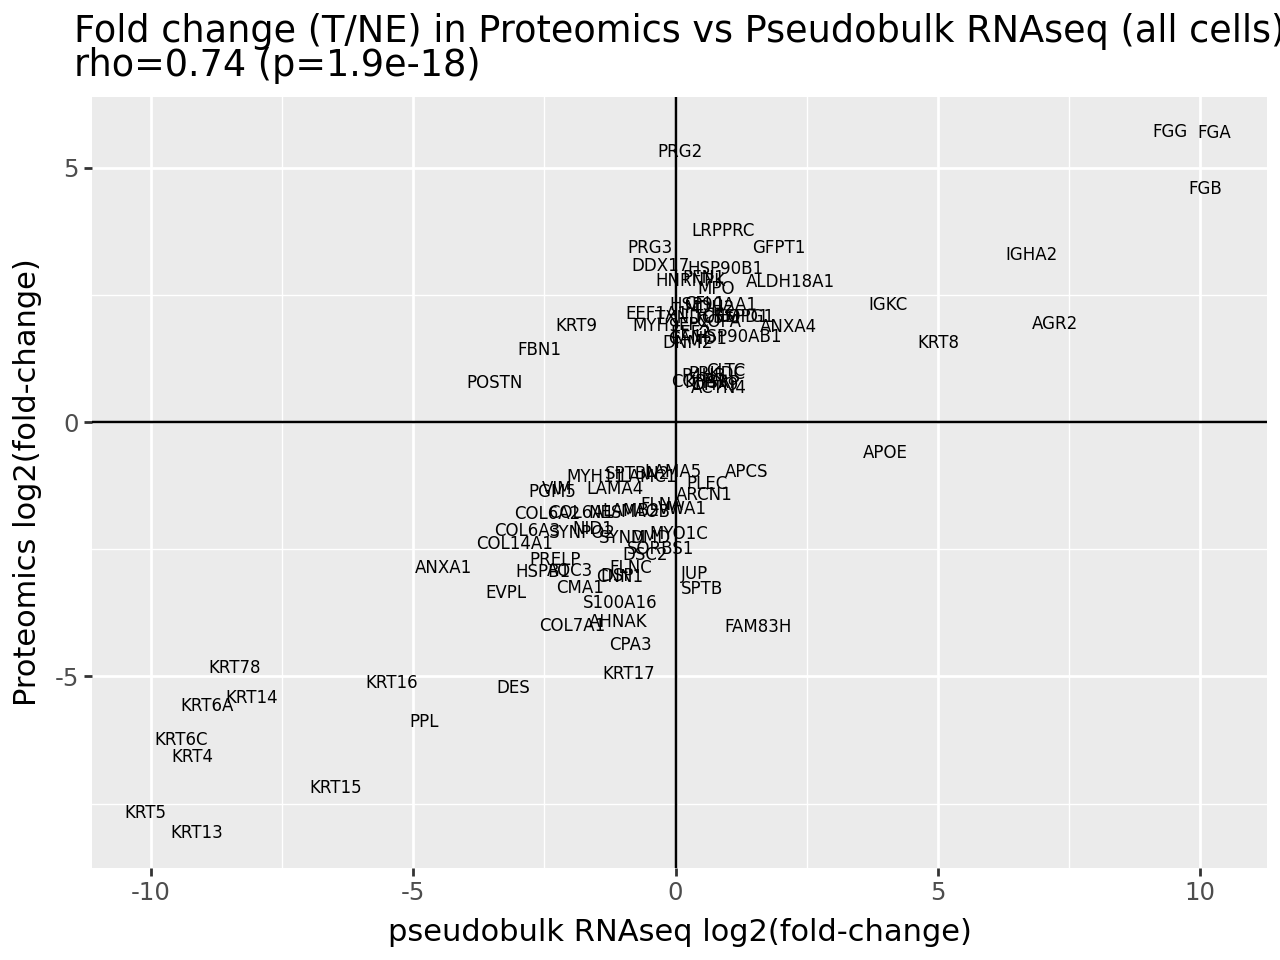

In [24]:
df_FC_sc_proteomics = _FC_pseudobulk_df\
 .merge(df_NE_vs_T.rename({'log2fc': 'log2fc_proteomics', 'qvalue': 'qvalue_proteomics'}, axis=1), on='gene')#\
 #.query('gene not in ["FGA","FGG","FGB"]')

from scipy.stats import spearmanr
rho, pval_rho = spearmanr(
    np.log2(df_FC_sc_proteomics.ratio_scrnaseq),
    df_FC_sc_proteomics.log2fc_proteomics)


p = pn.ggplot(df_FC_sc_proteomics,
          pn.aes('np.log2(ratio_scrnaseq)', 'log2fc_proteomics', label='gene' ))\
+ pn.geom_text(size=6) + pn.geom_vline(xintercept=0) + pn.geom_hline(yintercept=0)\
+ pn.labs(title=f'Fold change (T/NE) in Proteomics vs Pseudobulk RNAseq (all cells)\nrho={rho:.2f} (p={pval_rho:.1e})', x='pseudobulk RNAseq log2(fold-change)', y='Proteomics log2(fold-change)')
p.save(f'{plotfolder}/ECM_FC_comparison.svg')
p

In [25]:
df_FC_sc_proteomics.query('gene=="POSTN"')

,index,delta_expression_scrnaseq,NE_expression_scrnaseq,T_expression_scrnaseq,ratio_scrnaseq,gene,log2fc_proteomics,qvalue_proteomics,Comparison (group1/group2),# of Ratios,Pvalue,up_or_down,Pvalue_clipped
37,37,-1607972.0,1771317.0,163345.0,0.092217,POSTN,0.78,0.000006,Tumor / AdjN,228,2.530000e-07,up,2.530000e-07


## Using Deseq to get FCs

In [26]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

In [27]:
pdata = dc.get_pseudobulk(A.raw.to_adata(),
                          sample_col='samplename',
                          groups_col='diagnosis',
                          mode='sum',
                          min_cells=50,
                         )
sc.pp.filter_genes(pdata, min_counts=1)
pdata

AnnData object with n_obs × n_vars = 12 × 30635
    obs: 'samplename', 'diagnosis', 'patient', 'procedure', 'dataset', 'psbulk_n_cells', 'psbulk_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'is_mito', 'is_ribo', 'old_genename', 'n_counts'
    layers: 'psbulk_props'

### Actual DE

#### with patient

In [28]:
dds = DeseqDataSet(
    adata=pdata.copy(),
    design_factors=['patient','diagnosis'],
    refit_cooks=True,
    n_cpus=8,
)
dds.deseq2()

stats_res = DeseqStats(dds, contrast=["diagnosis",  "T", "NE"],)
stats_res.summary()
# stats_res.lfc_shrink(coeff='diagnosis_T_vs_M')
df_DE= stats_res.results_df


stats_res = DeseqStats(dds, contrast=["diagnosis",  "T", "NE"], )
stats_res.summary()
stats_res.lfc_shrink(coeff='diagnosis_T_vs_NE')
df_DE_shrink= stats_res.results_df

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 7.22 seconds.

Fitting dispersion trend curve...
/opt/conda/lib/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
... done in 1.85 seconds.

Fitting MAP dispersions...
... done in 10.35 seconds.

Fitting LFCs...
... done in 7.30 seconds.

Calculating cook's distance...
... done in 0.04 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 10.02 seconds.



Log2 fold change & Wald test p-value: diagnosis T vs NE
           baseMean  log2FoldChange     lfcSE      stat        pvalue  \
A1BG     846.668689       -0.260669  0.316446 -0.823739  4.100881e-01   
A1CF     278.250432        2.774126  0.871608  3.182767  1.458749e-03   
A2M     7095.578301       -1.457434  0.541324 -2.692348  7.095088e-03   
A2ML1   2822.790629       -4.360584  0.735807 -5.926257  3.099174e-09   
A2MP1     40.693225       -1.211300  0.654574 -1.850517  6.423913e-02   
...             ...             ...       ...       ...           ...   
ZYG11A   115.021160       -0.218916  0.238647 -0.917320  3.589748e-01   
ZYG11B  1033.622988       -0.277451  0.136018 -2.039807  4.136952e-02   
ZYX     1660.163932        0.152574  0.217311  0.702102  4.826158e-01   
ZZEF1    629.490999        0.038240  0.219647  0.174097  8.617891e-01   
ZZZ3     869.713641        0.831793  0.428917  1.939285  5.246660e-02   

                padj  
A1BG    6.313400e-01  
A1CF    1.166262e-02 

Running Wald tests...
... done in 3.12 seconds.



Log2 fold change & Wald test p-value: diagnosis T vs NE
           baseMean  log2FoldChange     lfcSE      stat        pvalue  \
A1BG     846.668689       -0.260669  0.316446 -0.823739  4.100881e-01   
A1CF     278.250432        2.774126  0.871608  3.182767  1.458749e-03   
A2M     7095.578301       -1.457434  0.541324 -2.692348  7.095088e-03   
A2ML1   2822.790629       -4.360584  0.735807 -5.926257  3.099174e-09   
A2MP1     40.693225       -1.211300  0.654574 -1.850517  6.423913e-02   
...             ...             ...       ...       ...           ...   
ZYG11A   115.021160       -0.218916  0.238647 -0.917320  3.589748e-01   
ZYG11B  1033.622988       -0.277451  0.136018 -2.039807  4.136952e-02   
ZYX     1660.163932        0.152574  0.217311  0.702102  4.826158e-01   
ZZEF1    629.490999        0.038240  0.219647  0.174097  8.617891e-01   
ZZZ3     869.713641        0.831793  0.428917  1.939285  5.246660e-02   

                padj  
A1BG    6.313400e-01  
A1CF    1.166262e-02 

Fitting MAP LFCs...


Shrunk log2 fold change & Wald test p-value: diagnosis T vs NE
           baseMean  log2FoldChange     lfcSE      stat        pvalue  \
A1BG     846.668689       -0.210056  0.272899 -0.823739  4.100881e-01   
A1CF     278.250432        1.998692  1.305542  3.182767  1.458749e-03   
A2M     7095.578301       -1.186737  0.673489 -2.692348  7.095088e-03   
A2ML1   2822.790629       -4.040208  0.880695 -5.926257  3.099174e-09   
A2MP1     40.693225       -0.621876  0.578206 -1.850517  6.423913e-02   
...             ...             ...       ...       ...           ...   
ZYG11A   115.021160       -0.191170  0.216781 -0.917320  3.589748e-01   
ZYG11B  1033.622988       -0.263030  0.132148 -2.039807  4.136952e-02   
ZYX     1660.163932        0.141330  0.195218  0.702102  4.826158e-01   
ZZEF1    629.490999        0.034629  0.200454  0.174097  8.617891e-01   
ZZZ3     869.713641        0.650668  0.386440  1.939285  5.246660e-02   

                padj  
A1BG    6.313400e-01  
A1CF    1.1662

... done in 6.74 seconds.



## Plots

In [29]:
from ecm_tools import plot_fc_comparision

#### diag+patient, unshrunkl

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 5 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /tmp/ECM_NE_vs_T/ECM_FC_comparison_unshrunk_patient_diag.svg


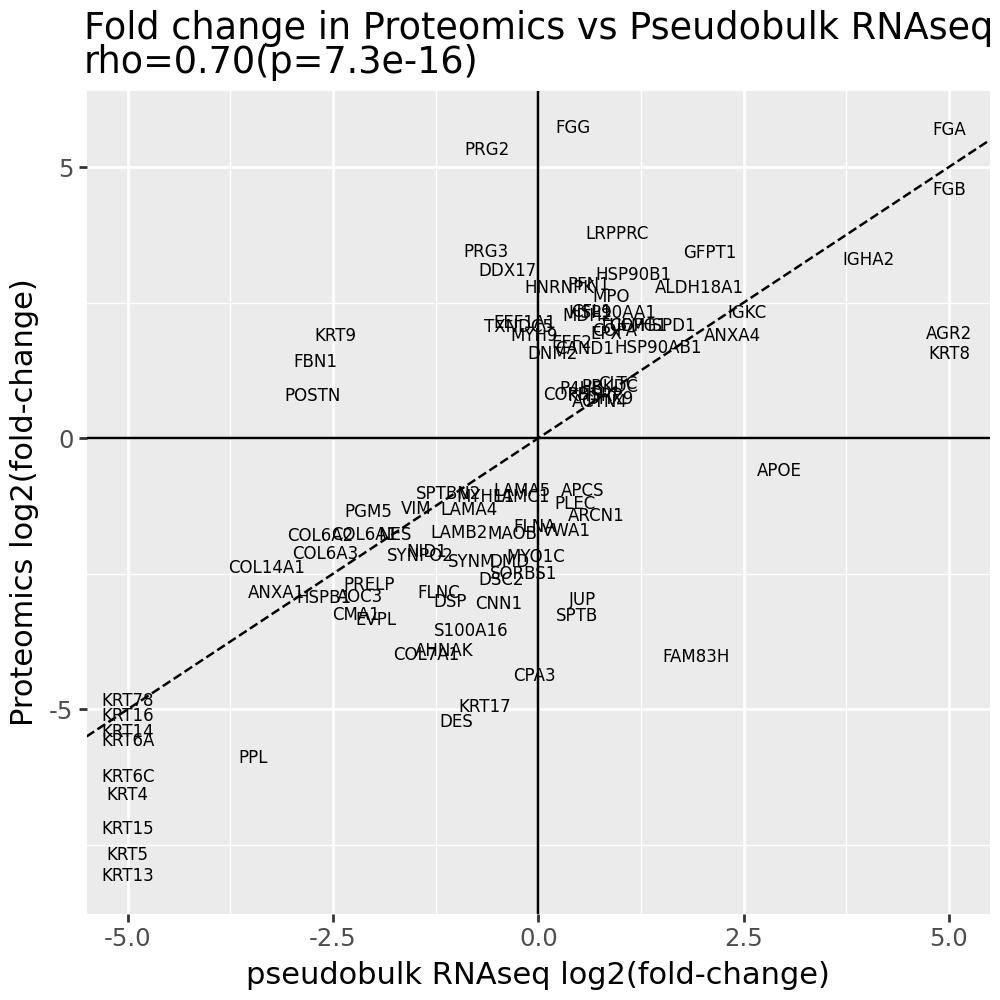

In [30]:
df = df_DE.merge(df_NE_vs_T.set_index('gene'), left_index=True, right_index=True).loc[genes_up+genes_down]
p = plot_fc_comparision(df, )+ pn.theme(figure_size=(5,5))
p.save(f'{plotfolder}/ECM_FC_comparison_unshrunk_patient_diag.svg')
p

#### patient + diag, with shrinkage

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 5 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /tmp/ECM_NE_vs_T/ECM_FC_comparison_shrunk_patient_diag.svg


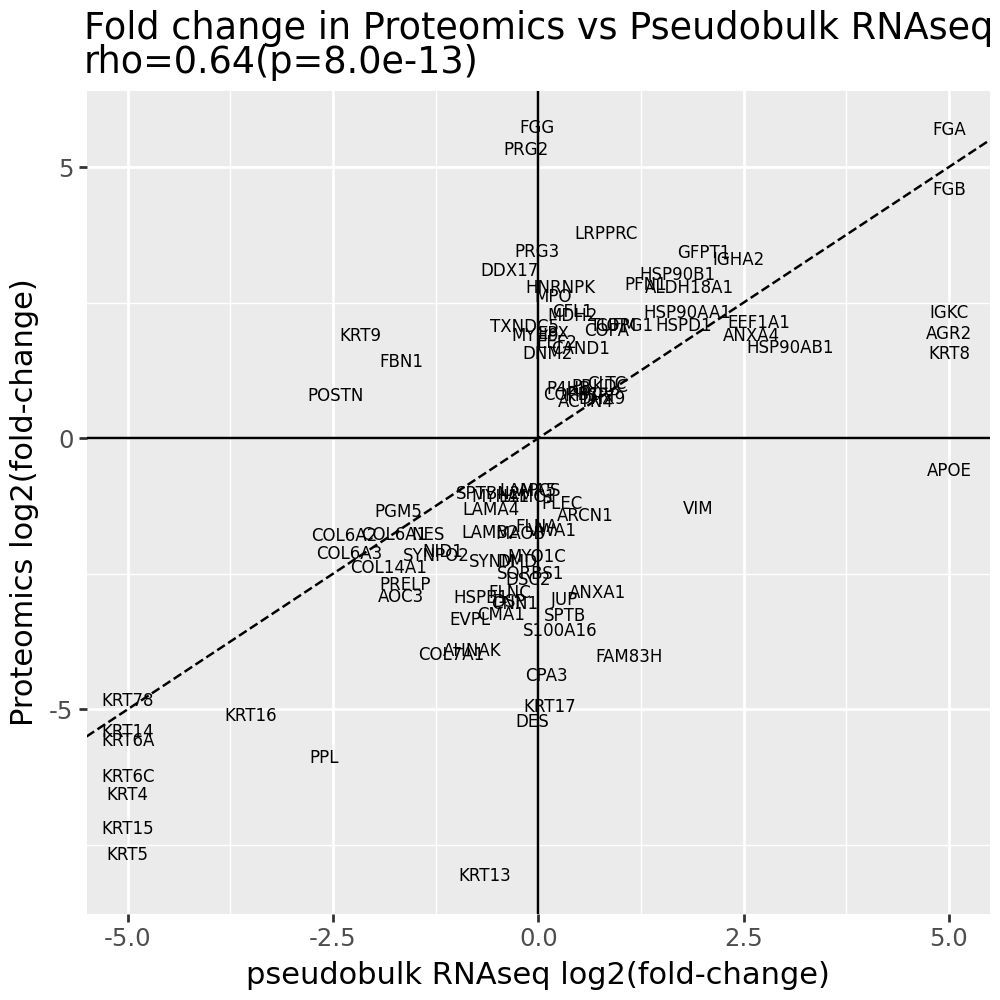

In [31]:
df = df_DE_shrink.merge(df_NE_vs_T.set_index('gene'), left_index=True, right_index=True).loc[genes_up+genes_down]
p = plot_fc_comparision(df)+ pn.theme(figure_size=(5,5))
p.save(f'{plotfolder}/ECM_FC_comparison_shrunk_patient_diag.svg')
p

# Fold change by cell type

In [32]:
from ecm_tools import suis_plot_fixed, ecm_lfc_via_deseq_python

In [33]:
colormap = pn.scale_color_manual(color_dict_coarse_celltype)
theme =  pn.theme(figure_size=(5,9), panel_background=pn.element_rect(fill='white', alpha=.2), line=pn.element_line(color='grey'))

## DEseq fold changes

In [34]:
from sctools.deseq import DESeq2_pseudobulk_wrapper, plot_pca_grid, covariate_pc_correlation

In [35]:
from ecm_tools import ecm_lfc_via_deseq_python, the_plot_shrunk, the_plot_unshrunk

In [36]:
A.obs['celltype_merge_epi']=A.obs['celltype_split'].astype(str)
A.obs['celltype_merge_epi'].replace({'Columnar Epithelium': 'Epithelium','Squamous Epithelium': "Epithelium"}, inplace=True)

### ~patient + diag

In [37]:
contrast = ["diagnosis",  "NE", "T"]
design_factors = ['patient','diagnosis']
df_de_all, adata_vsds =  ecm_lfc_via_deseq_python(A, design_factors, contrast=contrast, gene_min_counts=10)
df_de_all['independent_filter'] = df_de_all.padj.apply(lambda x: 'filtered' if np.isnan(x) else 'ok')

Celltype: Myeloid


Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 3.04 seconds.

Fitting dispersion trend curve...
... done in 2.22 seconds.

Fitting MAP dispersions...
... done in 3.00 seconds.

Fitting LFCs...
... done in 4.12 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.



Fit type used for VST : parametric


Fitting dispersions...
... done in 2.40 seconds.



Celltype: Fibroblasts


Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 2.93 seconds.

Fitting dispersion trend curve...
... done in 2.76 seconds.

Fitting MAP dispersions...
... done in 3.34 seconds.

Fitting LFCs...
... done in 3.29 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.



Fit type used for VST : parametric


Fitting dispersions...
... done in 3.27 seconds.



Celltype: Bcells


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 2.12 seconds.

Fitting dispersion trend curve...
... done in 0.96 seconds.

/opt/conda/lib/python3.11/site-packages/pydeseq2/dds.py:497: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
Fitting MAP dispersions...
... done in 3.69 seconds.

Fitting LFCs...
... done in 3.92 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.



Fit type used for VST : parametric


Fitting dispersions...
... done in 1.83 seconds.



Celltype: Epithelium


Fitting size factors...
... done in 0.03 seconds.

Fitting dispersions...
... done in 3.97 seconds.

Fitting dispersion trend curve...
... done in 2.22 seconds.

Fitting MAP dispersions...
... done in 3.51 seconds.

Fitting LFCs...
... done in 3.98 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.



Fit type used for VST : parametric


Fitting dispersions...
... done in 2.12 seconds.



Celltype: Myofibroblasts


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 2.22 seconds.

Fitting dispersion trend curve...
... done in 0.64 seconds.

/opt/conda/lib/python3.11/site-packages/pydeseq2/dds.py:497: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
Fitting MAP dispersions...
... done in 3.57 seconds.

Fitting LFCs...
... done in 2.81 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.



Fit type used for VST : parametric


Fitting dispersions...
... done in 1.23 seconds.



Celltype: Tcells


Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 3.71 seconds.

Fitting dispersion trend curve...
... done in 2.55 seconds.

Fitting MAP dispersions...
... done in 3.37 seconds.

Fitting LFCs...
... done in 3.39 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.



Fit type used for VST : parametric


Fitting dispersions...
... done in 1.78 seconds.



Celltype: Endothelial cells


Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 2.68 seconds.

Fitting dispersion trend curve...
... done in 0.46 seconds.

Fitting MAP dispersions...
... done in 2.77 seconds.

Fitting LFCs...
... done in 3.03 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.



Fit type used for VST : parametric


Fitting dispersions...
... done in 1.88 seconds.



Celltype: Mast cells


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 1.00 seconds.

Fitting dispersion trend curve...
... done in 0.28 seconds.

Fitting MAP dispersions...
... done in 1.65 seconds.

Fitting LFCs...
... done in 1.51 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.



Fit type used for VST : parametric


Fitting dispersions...
... done in 1.07 seconds.



Celltype: Other


In [38]:
# pn.ggplot(df_de_all, pn.aes('pvalue', fill='independent_filter')) + pn.geom_histogram(bins=20) + pn.facet_wrap('celltype') +  pn.theme(figure_size=(7,7))

#### unshrunk

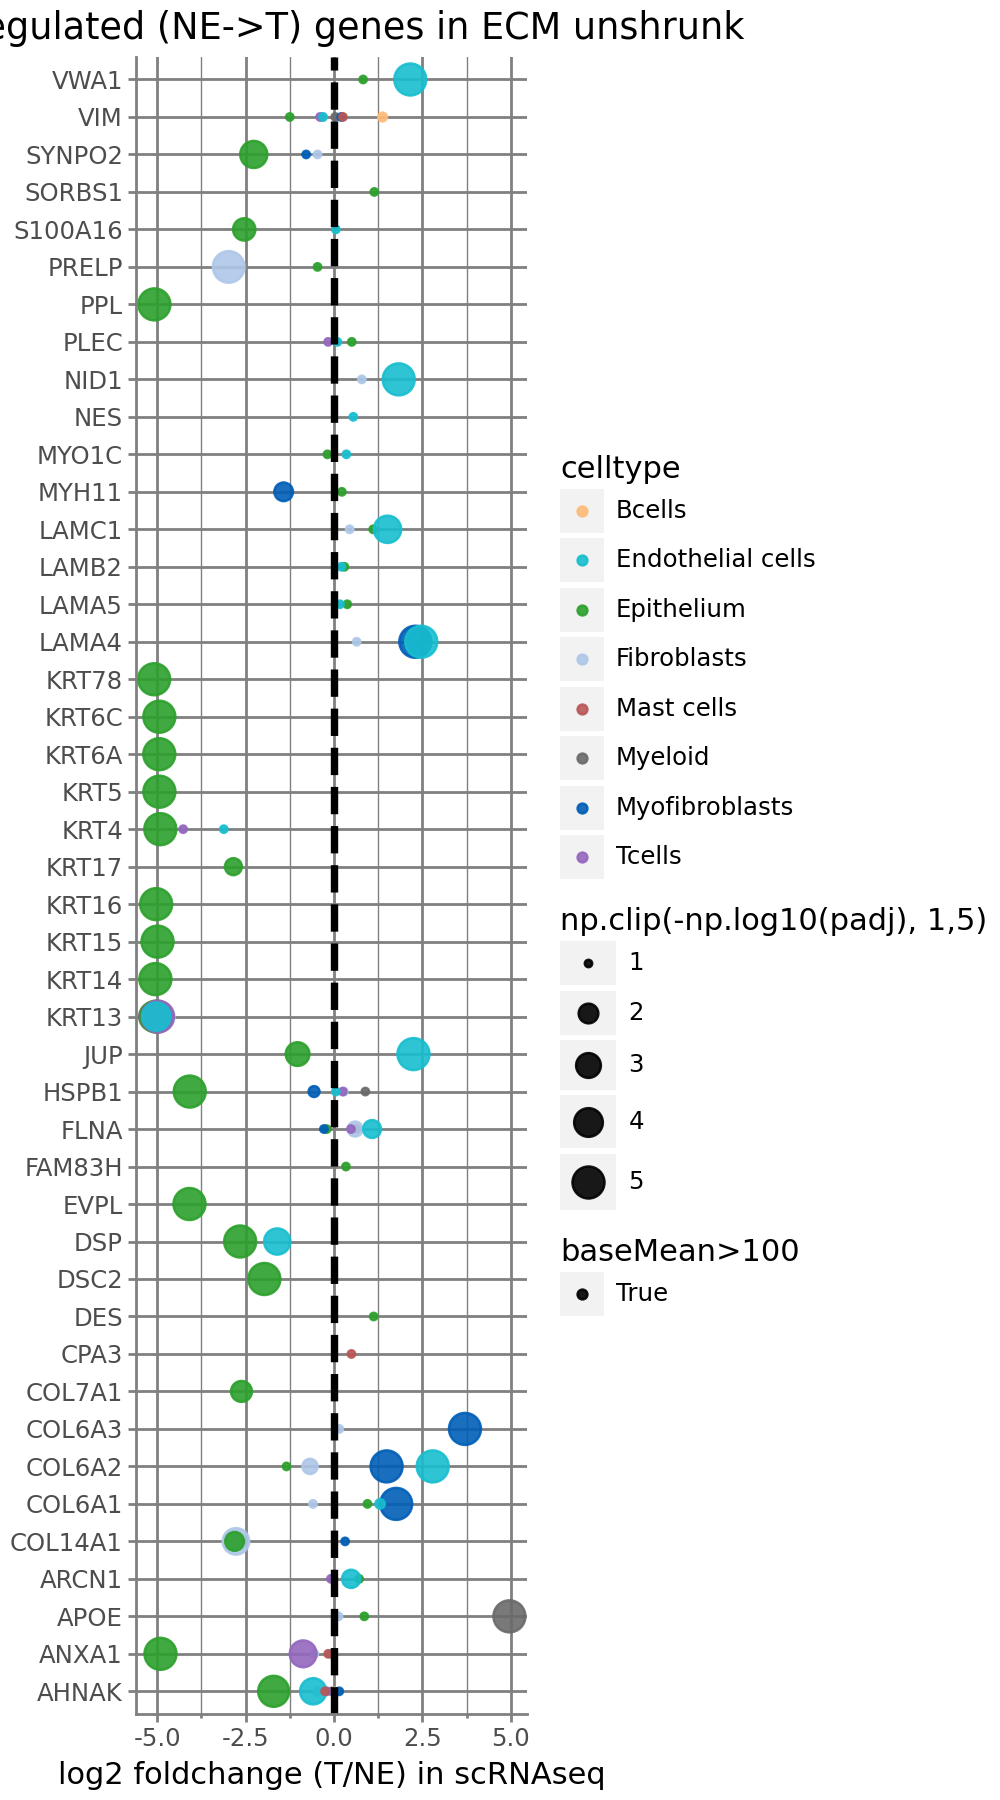

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 9 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /tmp/ECM_NE_vs_T/ECM_DESeq_FC_per_celltype_up_patient_diag_unshrunk.svg


In [39]:
p2 = the_plot_unshrunk(df_de_all.loc[[_ for _ in genes_down if _ in  df_de_all.index]].reset_index().query("baseMean>100")) + pn.labs(x='log2 foldchange (T/NE) in scRNAseq', title='Upregulated (NE->T) genes in ECM unshrunk', y='')
p2.show()
p2.save(f'{plotfolder}/ECM_DESeq_FC_per_celltype_up_patient_diag_unshrunk.svg')

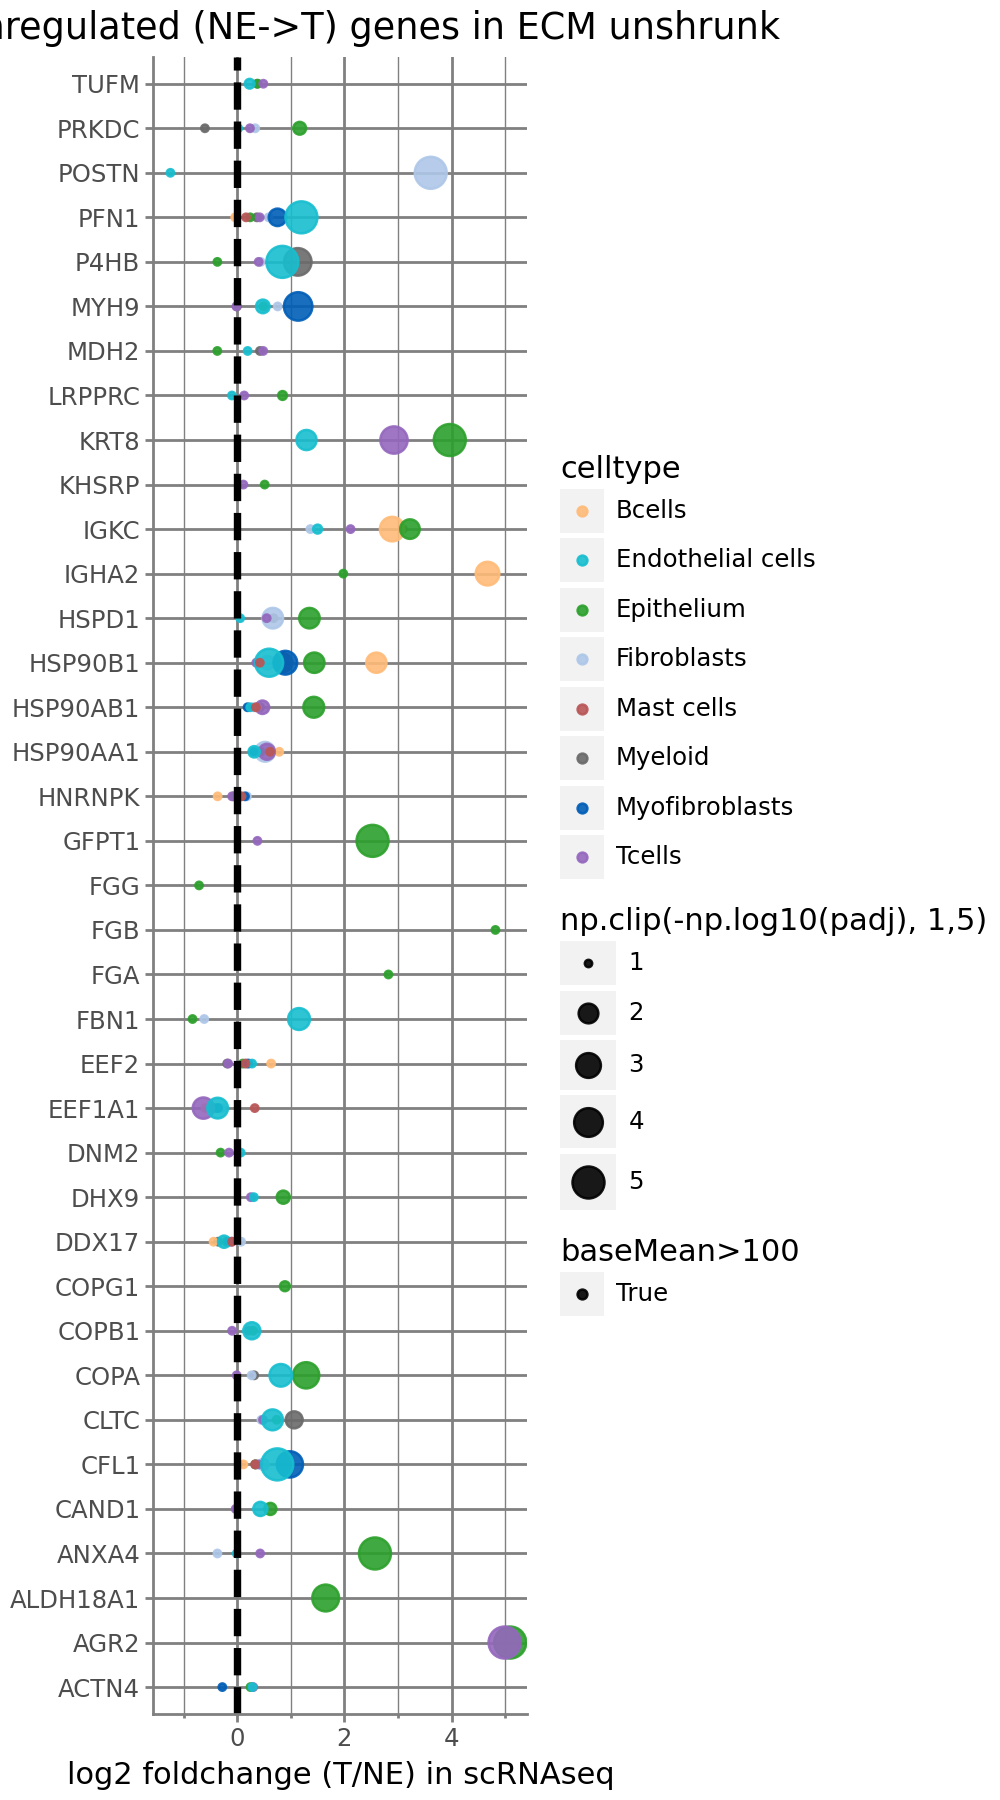

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 9 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /tmp/ECM_NE_vs_T/ECM_DESeq_FC_per_celltype_up_patient_diag_unshrunk.svg


In [40]:
p2 = the_plot_unshrunk(df_de_all.loc[[_ for _ in genes_up if _ in  df_de_all.index]].reset_index().query("baseMean>100")) + pn.labs(x='log2 foldchange (T/NE) in scRNAseq', title='Downregulated (NE->T) genes in ECM unshrunk', y='')
p2.show()
p2.save(f'{plotfolder}/ECM_DESeq_FC_per_celltype_up_patient_diag_unshrunk.svg')

# Gene Boxplots

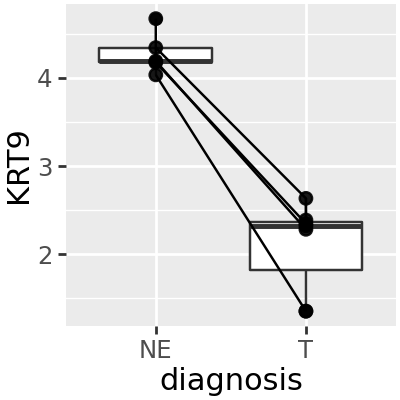

In [41]:
vsd = adata_vsds['Epithelium'].copy()
plot_gene('KRT9', vsd, grouping_var='diagnosis') + pn.theme(figure_size=(2,2))

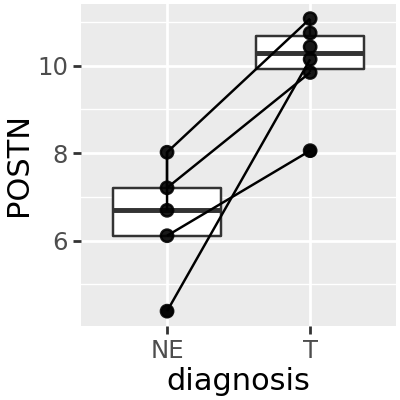

In [42]:
vsd = adata_vsds['Fibroblasts'].copy()
plot_gene('POSTN', vsd, grouping_var='diagnosis') + pn.theme(figure_size=(2,2))

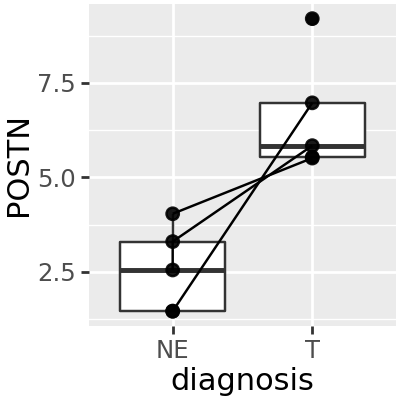

In [43]:
vsd = adata_vsds['Myofibroblasts'].copy()
plot_gene('POSTN', vsd, grouping_var='diagnosis') + pn.theme(figure_size=(2,2))

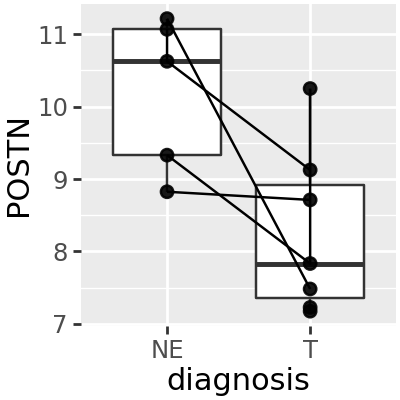

In [44]:
vsd = adata_vsds['Endothelial cells'].copy()
plot_gene('POSTN', vsd, grouping_var='diagnosis') + pn.theme(figure_size=(2,2))